# Generative Adversarial Network
在这次项目中，我们将建立一个基于**MNIST数据集**的生成对抗网络（GAN）。由此，我们将能够生成新的手写数字！

GANS[第一次报道](https://arxiv.org/abs/1406.2661)来自Ian Goodfellow和Yoshua Bengio实验室的其他人。此后，GANS流行起来。下面是几个例子：

* [Pix2Pix](https://affinelayer.com/pixsrv/) 
* [CycleGAN](https://github.com/junyanz/CycleGAN)
* [A whole list](https://github.com/wiseodd/generative-models)

GANs背后的想法是，你有两个网络，一个生成器$G$，一个鉴别器$D$，相互竞争。生成器生成假数据以传递给鉴别器。鉴别器还可以看到真实的数据，并预测接收到的数据是真是假。生成器被训练来欺骗鉴别器，它希望输出看起来尽可能接近真实数据的数据。然后训练鉴别器找出哪些数据是真实的，哪些是假的。最终的结果是，生成器学会将无法从实际数据中区分的数据转换为鉴别器。

![GAN diagram](assets/gan_diagram.png)

GAN的一般结构如上图所示，使用**MNIST图像**作为数据。潜在样本是一个随机向量，生成器用来构造它的假图像。当生成器通过训练学习时，它会找出如何将这些随机向量映射到能够欺骗鉴别器的可识别图像。
鉴别器的输出是一个Sigmoid函数，其中0表示假图像，1表示真图像。如果你只对生成新的图像感兴趣，你可以在训练后扔掉鉴别器。现在，让我们看看如何在TensorFlow中构建这个东西。

In [1]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
%%time
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
CPU times: user 13.9 s, sys: 720 ms, total: 14.6 s
Wall time: 16.2 s


## Model Inputs

首先我们需要为我们的图创建输入。我们需要两个输入，一个用于鉴别器，一个用于发生器。这里我们将鉴别器输入称为`inputs_real`，生成器输入称为`inputs_z`。我们将为每个网络分配适当的大小。

>**练习：** 完成下面的`model_inputs`功能。分别使用输入大小(`real_dim`和`z_dim`)为`inputs_real`和`inputs_z`创建占位符。

In [3]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, shape=(None, real_dim), name="real")
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="z")
    
    return inputs_real, inputs_z

model_inputs(9, 9)

(<tf.Tensor 'real:0' shape=(?, 9) dtype=float32>,
 <tf.Tensor 'z:0' shape=(?, 9) dtype=float32>)

## Generator network

![GAN Network](assets/gan_network.png)

在这里我们将建立生成器网络。为了使这个网络成为通用函数逼近器，我们需要至少一个隐藏层。我们应该使用一个leaky ReLU来允许梯度在不受阻碍的情况下向后流过该层。leaky ReLU类似于正常ReLU，只是对于负输入值有一个小的非零输出。

#### Variable Scope
- 这里我们需要使用`tf.variable_scope`有两个原因。
    - 首先，我们要确保所有变量名都以`generator`开头。
    - 同样，我们将在鉴别器变量前面加上`discriminator`。这将有助于我们以后培训单独的网络。     
    
我们可以使用`tf.name_scope`来设置名称，但我们也希望用不同的输入重用这些网络。对于生成器，我们将对其进行训练，但也要在训练时和训练后*从中取样*。鉴别器需要在假图像和真图像之间共享变量。因此，我们可以使用`tf.variable_scope`的`reuse`关键字告诉TensorFlow重用变量，而不是在再次构建图时创建新的变量。

To use `tf.variable_scope`, you use a `with` statement:
```python
with tf.variable_scope('scope_name', reuse=False):
    # code here
```

以下是[TensorFlow 1.x文档](https://tensorflow.google.cn/api_docs/python/tf/compat/v1/variable_scope?hl=zh_cn)中的更多内容，以进一步了解如何使用`tf.variable_scope`。

#### Leaky ReLU
TensorFlow不为泄漏的ReLUs提供操作，所以我们需要做一个。为此，您可以只从一个线性完全连接层的输出，并将它们传递到`tf.maximum`。通常，参数`alpha`设置负值的输出大小。因此，负输入（`x`）值的输出是`alpha*x`，正输入（`x`）值的输出是`x`：
$$
f(x) = max(\alpha * x, x)
$$

#### Tanh Output
当生成器的输出为$tanh$性能最好。这意味着我们必须重新缩放MNIST图像，使其介于-1和1之间，而不是0和1之间。

>**练习：** 在下面的函数中实现生成器网络。您需要返回tanh输出。确保将代码包装在变量作用域中，作用域名称为“generator”，并将函数中的`reuse`关键字参数传递给`tf.variable_scope`。

In [4]:
def generator(z, out_dim, n_units=128, reuse=False,  alpha=0.01):
    ''' Build the generator network.
    
        Arguments
        ---------
        z : Input tensor for the generator
        out_dim : Shape of the generator output
        n_units : Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # Logits and tanh output
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out

## Discriminator

鉴别器网络几乎和生成器网络完全一样，只是我们使用的是一个Sigmoid输出层。
>**练习：** 在下面的函数中实现鉴别器网络。与上面一样，您需要返回logits和sigmoid输出。请确保将代码包装在变量作用域中，作用域名称为`discriminator`，并将函数参数中的`reuse`关键字参数传递给`tf.variable_scope`。

In [5]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    ''' Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        n_units: Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope('discriminator', reuse=reuse): # finish this
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        
        logits = tf.layers.dense(h1, 1, activation=None)   # logit is score(output dimension is 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Hyperparameters

In [6]:
# Size of input image to discriminator
input_size = 784 # 28x28 MNIST images flattened
# Size of latent vector to generator
z_size = 100

n_units = 128

# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Label smoothing 
smooth = 0.1

## Build network

- 现在我们正在根据上面定义的函数构建网络。   

    - 首先是使用输入的大小`input_real`和z的大小`input_z`，从`model_inputs`中获取输入。   
    - 然后，我们将创建生成器，`generator（input_z, input_size）`。这将生成具有适当输入和输出大小的生成器。   
    - 然后是鉴别器，我们将构建其中两个，一个用于真实数据，另一个用于假数据。因为我们希望真实数据和假数据的权重相同，所以需要重用变量。对于假数据，我们从生成器中获取它作为`g_model`。因此，真正的数据鉴别器是`discriminator（input_real）`，而伪鉴别器是`discriminator（gúmodel, reuse=True）`。     
>**练习：**根据前面定义的函数构建网络。

In [7]:
%%time
#  Clears the default graph stack and resets the global default graph
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Build the model
g_model = generator(input_z, input_size, n_units=n_units, alpha=alpha)
# g_model is the generator output

d_model_real, d_logits_real = discriminator(input_real, n_units=n_units, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=n_units, alpha=alpha)

CPU times: user 61.3 ms, sys: 83 µs, total: 61.3 ms
Wall time: 64.3 ms


## Discriminator and Generator Losses

现在我们需要计算损失，这有点棘手。对于鉴别器，总损失是真图像和假图像的损失之和，`d_loss=d_loss_real + d_loss_fake`。损失是由Sigmoid CEL计算的，我们可以用`tf.nn.sigmoid_cross_entropy_with_logits`来计算。我们还将用`tf.reduce_mean`将其包装起来，以获得批处理中所有图像的平均值。所以损失看起来像

```python
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
```

对于真实图像logit，我们将使用从上面单元格中的鉴别器获得的`d_logits_real`。对于标签，我们希望它们都是完整的，因为这些都是真实的图像。为了帮助鉴别器更好地泛化，标签会从1.0减少到0.9，例如，使用参数`smooth`。这称为标签平滑，通常与分类器一起使用以提高性能。在TensorFlow中，它类似于`labels=tf.one_like（tensor）*（1-smooth）`       
             
伪数据的鉴别器损失是相似的。logits是`d_logits_fake`，我们通过将生成器输出传递给鉴别器得到。这些假logit与所有零的标签一起使用。请记住，我们希望鉴别器为真实图像输出1，为假图像输出0，因此我们需要设置损失来反映这一点。   
      
最后，生成器的损失是使用了`d_logits_fake`，即伪图像logits。但是，现在所有的标签都是一样的。生成器试图欺骗鉴别器，因此它希望鉴别器输出用于伪图像的图像。

>**练习：** 计算鉴别器和生成器的损失。有两个鉴别器损失，一个用于真实图像，一个用于假图像。对于真实的图像损失，使用真实的logits和（平滑的）标签。对于伪图像损失，请使用标签都为零的伪logits。总鉴别器损失是这两个损失的总和。最后，生成器损失再次使用来自鉴别器的假logit，但这次标签都是假的，因为生成器想欺骗鉴别器。

In [8]:
d_logits_real, d_logits_fake

(<tf.Tensor 'discriminator/dense_2/BiasAdd:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'discriminator_1/dense_2/BiasAdd:0' shape=(?, 1) dtype=float32>)

In [9]:
%%time
# Calculate losses
d_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, 
        labels=tf.ones_like(d_logits_real) * (1 - smooth)     # real is all 1
    )
)
d_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, 
        labels=tf.zeros_like(d_logits_fake)                 # fake is all 0
    )
)
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake,
        labels=tf.ones_like(d_logits_fake)               # 
    )
)

CPU times: user 27.9 ms, sys: 263 µs, total: 28.1 ms
Wall time: 30.5 ms


## Optimizers

我们要分别更新生成器和鉴别器变量。所以我们需要得到每个部分的变量，并为这两个部分构建优化器。要获取所有可训练变量，我们使用`tf.trainable_variables（）`。这将创建我们在图中定义的所有变量的列表。
          
对于生成器优化器，我们只希望生成变量。我们过去的自我很好，使用一个变量作用域以`generator`开始我们所有的生成器变量名。所以，我们只需要遍历来自`tf.trainable_variables()`的列表，并保留以`generator`开头的变量。每个变量对象都有一个属性`name`，该属性将变量的名称保存为字符串（例如，`var.name=='weights_0'`）。           
              
我们可以用鉴别器做类似的事情。鉴别器中的所有变量都以`discriminator`开头。       
             
然后，在优化器中，我们将变量列表传递给`minimize`方法的`var_list`关键字参数。这告诉优化器只更新列出的变量。类似于`tf.train.AdamOptimizer().minimize（loss，var_list=var_list）`的操作只训练`var_list`中的变量。      
          
>**练习：** 下面，实现生成器和鉴别器的优化器。首先需要得到一个可训练变量的列表，然后将该列表分成两个列表，一个用于生成器变量，另一个用于鉴别器变量。最后，使用`AdamOptimizer`，为每个单独更新网络变量的网络创建一个优化器。

In [10]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

## Training

In [10]:
%%time
batch_size = 100
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, reuse=True),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.3528... Generator Loss: 4.0095
Epoch 2/100... Discriminator Loss: 0.3741... Generator Loss: 3.6286
Epoch 3/100... Discriminator Loss: 0.5049... Generator Loss: 4.5370
Epoch 4/100... Discriminator Loss: 0.4621... Generator Loss: 4.1551
Epoch 5/100... Discriminator Loss: 0.5219... Generator Loss: 3.3712
Epoch 6/100... Discriminator Loss: 0.5407... Generator Loss: 4.5423
Epoch 7/100... Discriminator Loss: 0.6832... Generator Loss: 3.0991
Epoch 8/100... Discriminator Loss: 0.8054... Generator Loss: 1.8641
Epoch 9/100... Discriminator Loss: 0.7704... Generator Loss: 2.2542
Epoch 10/100... Discriminator Loss: 0.8691... Generator Loss: 2.1364
Epoch 11/100... Discriminator Loss: 0.9059... Generator Loss: 1.7550
Epoch 12/100... Discriminator Loss: 0.7826... Generator Loss: 2.7612
Epoch 13/100... Discriminator Loss: 0.8121... Generator Loss: 3.5496
Epoch 14/100... Discriminator Loss: 0.7928... Generator Loss: 4.0735
Epoch 15/100... Discriminator Loss: 0.6942.

## Training loss

在这里我们将检查生成器和鉴别器的训练损失。

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

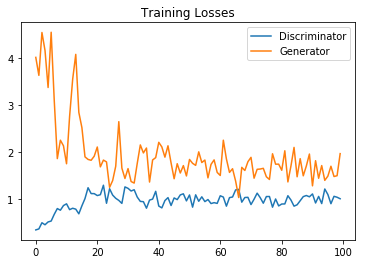

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

在这里我们可以查看来自生成器的图像样本。首先我们来看看训练时得到的照片。

In [12]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [13]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

这些是最后一次训练的样本。您可以看到生成器能够重现5、7、3、0、9等数字。因为这只是一个示例，所以它不能代表生成器可以生成的全部图像范围。

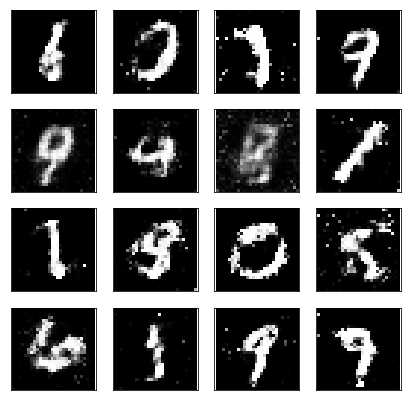

In [14]:
_ = view_samples(-1, samples)

下面我将展示网络训练时生成的图像，每10个阶段。有额外的幻觉！

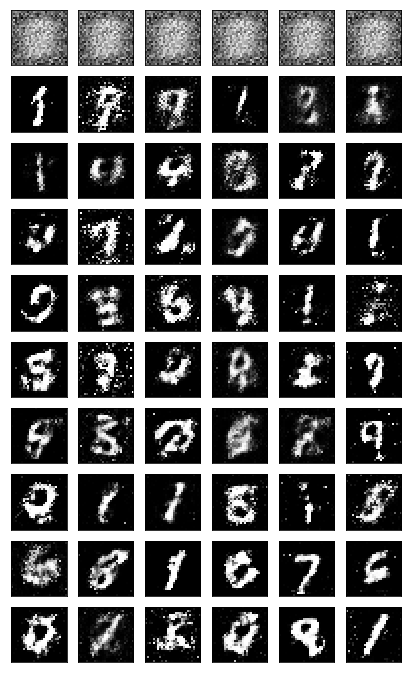

In [15]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

一开始都是噪音。然后它学会了只让中间的白色，其余的黑色。你可以开始看到一些类似数字的结构出现在噪音中。看起来1，9，8先出现了。然后，它学习5和3。

## Sampling from the generator

我们还可以通过使用训练后保存的检查点从生成器获取全新的图像。我们只需要传入一个新的潜在向量$z$，我们就会得到新的样本！

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


(<matplotlib.figure.Figure at 0x7ff4945d5e80>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff478588588>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7ff472b19e80>]], dtype=object))

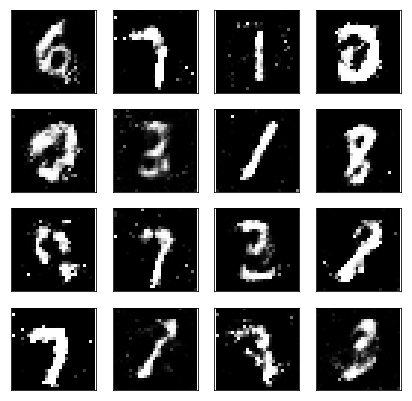

In [16]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(
                   generator(input_z, input_size, reuse=True),
                   feed_dict={input_z: sample_z})
view_samples(0, [gen_samples])

$$\;$$